<a href="https://colab.research.google.com/github/FrankGangWang/AppliedML_Python_Coursera/blob/master/Copy_of_Copy_of_Copy_of_Interview_for_DataScience_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Interview questions to test data science skills**

---




# Let's load the data from public GitHub account

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import statsmodels.api as sm



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_pickle("https://github.com/manjiler/interview_for_datascience/raw/master/interview_storage.pkl")
df['timestamp'] = df['timestamp']/1e3

In [ ]:
df.head(5)

,systemId,timestamp,model_type,cpu_utilization,read_cache_miss,write_cache_miss,read_iops,write_iops,read_throughput,write_throughput,read_iosz,write_iosz
0,sys1,1.572807e+09,A,18.701342,24.334389,71.529175,12990.702148,13171.539062,502967.31250,359029.093750,38.720345,27.258642
1,sys2,1.572812e+09,A,10.630484,11.163696,64.186844,34157.523438,25964.236328,482210.59375,537779.562500,14.117196,20.712614
2,sys3,1.572812e+09,B,5.637269,7.230949,62.729401,11787.345703,5525.521484,394009.28125,172450.578125,33.425911,31.209654
3,sys4,1.572813e+09,A,3.380666,13.382729,56.605385,28032.042969,14931.455078,412009.06250,205794.531250,14.697840,13.782779
4,sys5,1.572817e+09,A,2.641213,17.485886,69.983536,22266.902344,7150.452148,658391.06250,225116.828125,29.568398,31.482992


## Now that the data is loaded. let's begin!!!

# **About the data**

---
This is time series data for one month collected for N number of devices

Columns

systemId - Device name

timestamp - epoch time when the sensor data was collected

model_type - Different versions/release/model of the device (similar to mobile models)

cpu_utilization - this percentage of how much the CPU is used on the device.

read_cache_miss - Percentage of read that were not present in the Cache

write_cache_miss - Percentage of write that were not present in the Cache

read_iops -  Number of read IOs per second (Input/Output)

write_iops -  Nummber of write IOs per second (Input/Output)

read_throughput - the read bandwidth per second (Units kbps)

write_throughput - the write bandwidth per second (Units kbps)

read_iosz - the block size for read Input/Output operations

write_iosz - the block size for write Input/Output operations


y -> cpu_utilization



## Q1. Do an EDA on the data, correlation plots, features that might be important for the modeling. Share your observations. Comment on how the data looks from modeling perspective

In [ ]:
# RUN this cell
# 1. Add datetime and set it as index
# 2. Sort by datetime
# 3. To help finding time periodicity (hourly/daily/weekly/monthly/yearly), 
#    add additional features like "time of day/week" by appling cos and sin to timestamp 

df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', origin='unix')
df.set_index(df['datetime'], inplace=True)

# IMPORTANT step: sort by time index
df.sort_index(inplace=True)

# add sin/cos for day/hour
hour = 60*60
day = 24*hour
week = 7*day
print(f'hour={hour}, day={day}')
week_offset = 3*day # as epoch 0 is Thursday 1970-01-01, and leap seconds 23:59:60
df['Week_Sin'] = np.sin((df['timestamp']+week_offset) * (2 * np.pi / week))
df['Week_Cos'] = np.cos((df['timestamp']+week_offset) * (2 * np.pi / week))
df['Day_Sin'] = np.sin(df['timestamp'] * (2 * np.pi / day))
df['Day_Cos'] = np.cos(df['timestamp'] * (2 * np.pi / day))
df['Hour_Sin'] = np.sin(df['timestamp'] * (2 * np.pi / hour))
df['Hour_Cos'] = np.cos(df['timestamp'] * (2 * np.pi / hour))


day=86400, hour=3600


In [ ]:
# Constants: 
# size of data for train, cross validation, test
TEST_SIZE = 0.2


In [ ]:
# check missing data; result: no missing data
df.info()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_corr(df, systemId_selected):
  if systemId_selected[0] == 'All':
    df_tmp = df
  else:  
    df_tmp = df[df['systemId']==systemId_selected[0]]
  sns.set_theme(style="white")
  # Compute the correlation matrix
  corr = df_tmp.corr()
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(15, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
  f.suptitle(f'systemId {systemId_selected[0]}')

  

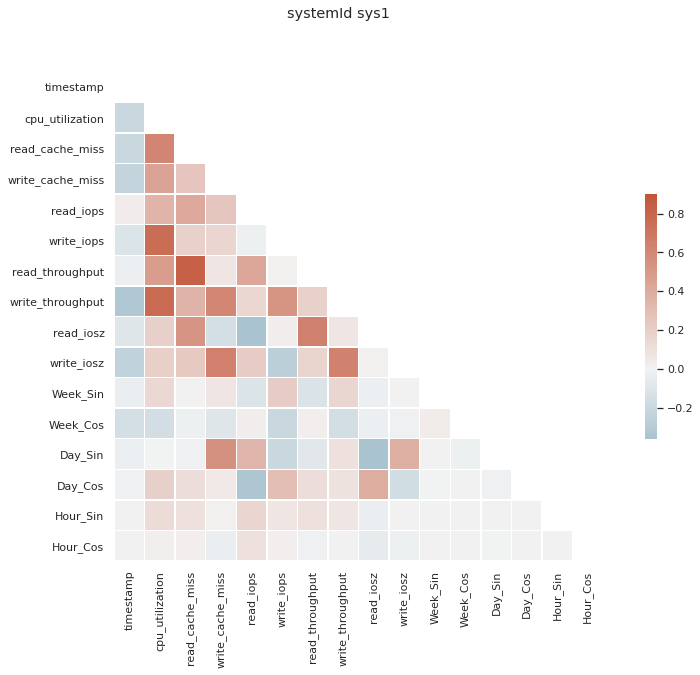

In [ ]:
systemId_selected = ['sys1']
plot_corr(df, systemId_selected)


**Observation** 
After comparison Correlation plots of two cases:
-- Case_SINGLE: Only extract a single systemId (here 'sys1') case; 
-- Case_ALL:  Use all systemIds as a whole;

Conclusion:
1. timestamp has low correlation with all the rest features; and is less useful directly;
2. Day_Cos and Day_Sin have good correlation with a few columns and shall help prediction;


Case_SINGLE clearly exposes a larger nuber of columns having high correlations with the target 'cpu_utilization' than  that of Case_ALL. 

1.1 columns having good correlation with 'cpu_utilization':
Case_SINGLE: ['write_throughput', 'write_iops', 'read_cache_miss', 'read_throughput', 'read_iops', 'write_cache_miss']

Case_ALL: ['read_throughput', 'read_cache_miss'] 
['write_cache_miss',  'read_iops', 'write_throughput', 'write_iosz' ]

1.1 columns having good correlation with Day_sin:  
Case_SINGLE ['write_cache_miss', 'read_iops', 'write_iosz' ]
Case_ALL: None

1.2 Day_Cos has good correlation with 2 columns:
Case_SINGLE: ['write_iops', 'read_iosz']
Case_ALL: None





In [ ]:
df.columns

Index(['systemId', 'timestamp', 'model_type', 'cpu_utilization',
       'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz',
       'datetime', 'Week_Sin', 'Week_Cos', 'Day_Sin', 'Day_Cos', 'Hour_Sin',
       'Hour_Cos'],
      dtype='object')

In [ ]:
systemId_selected = ['All']
plot_corr(df, systemId_selected)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

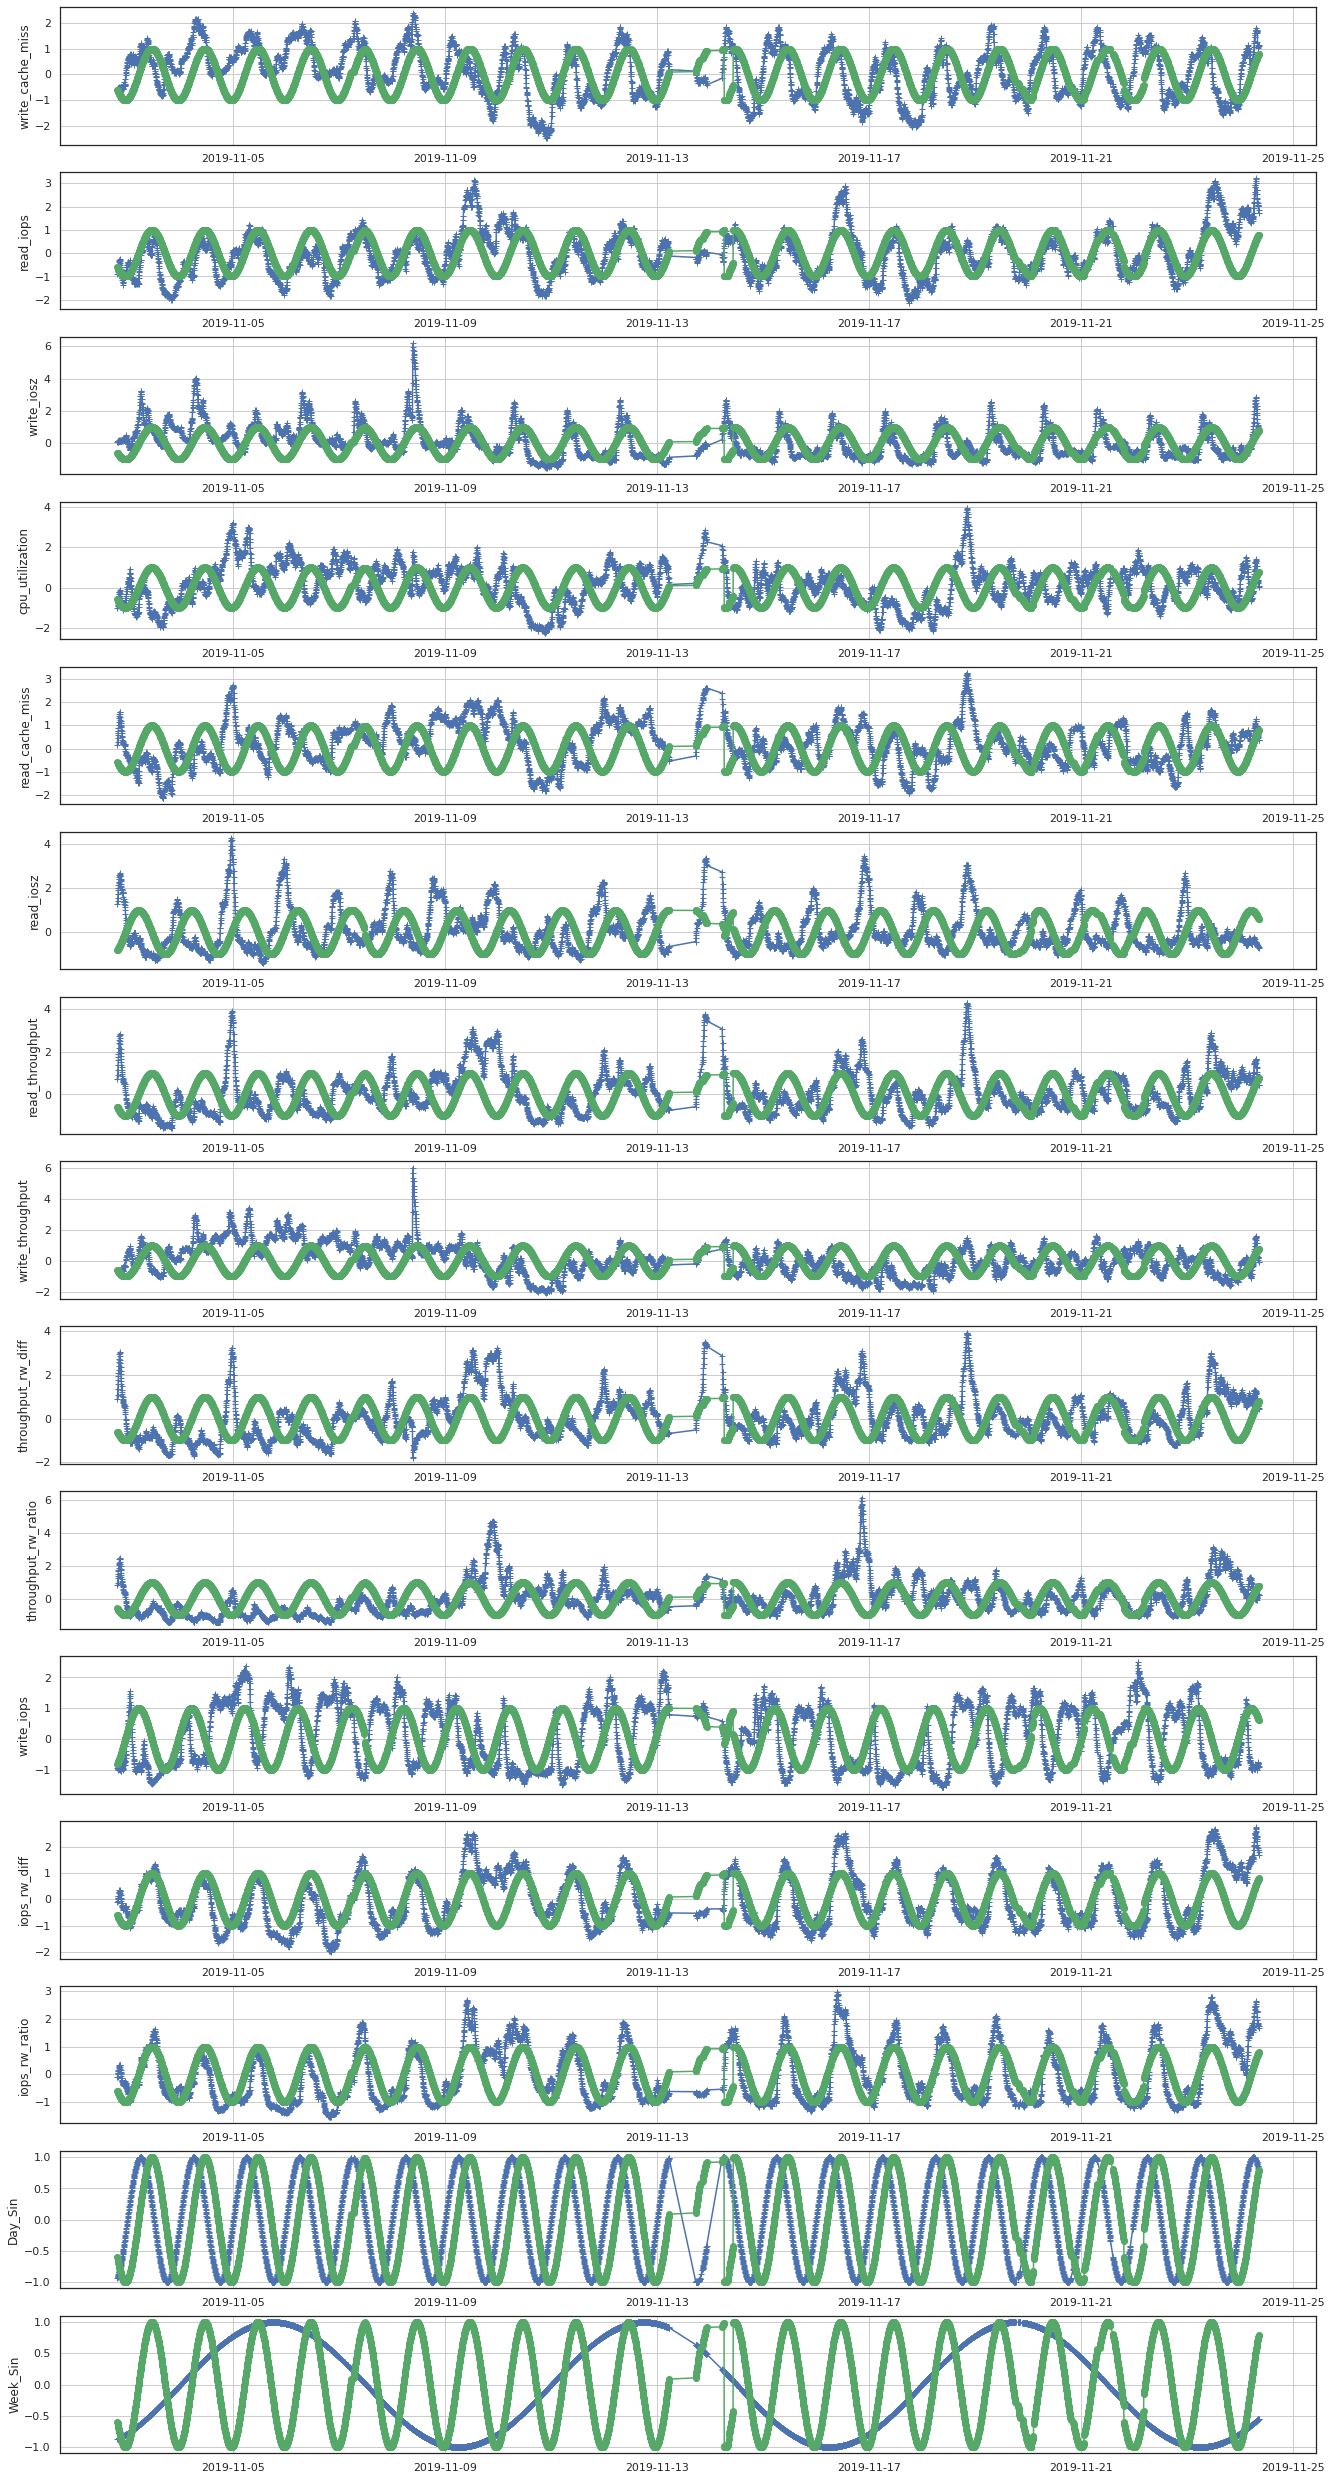

In [ ]:
df1 = df[df['systemId']=='sys1']

start_hour = 24*1+15;
interval_hour= 24*20 + 10
start = int(start_hour*hour/(5*60))
stop = int((start_hour + interval_hour)*hour/(5*60))

#x = df1['timestamp']
df1['iops_rw_diff'] = df1['read_iops'] - df1['write_iops']
df1['iops_rw_ratio'] = df1['read_iops']/df1['write_iops']

df1['throughput_rw_diff'] = df1['read_throughput'] - df1['write_throughput']
df1['throughput_rw_ratio'] = df1['read_throughput'] / df1['write_throughput']

cols = ['write_cache_miss',  'read_iops', 'write_iosz', 'cpu_utilization', 'read_cache_miss', 
        'read_iosz', 'read_throughput', 'write_throughput', 'throughput_rw_diff', 'throughput_rw_ratio',
        'write_iops', 'iops_rw_diff', 'iops_rw_ratio', 'Day_Sin', 'Week_Sin']#, 'Hour_Sin']

### moving average and standarization
cols_to_avg = ['cpu_utilization', 'read_cache_miss', 'write_cache_miss',
               'read_iosz', 'write_iosz', 'read_throughput', 'write_throughput', 'read_iops',
        'write_iops','throughput_rw_diff', 'throughput_rw_ratio', 'iops_rw_diff', 'iops_rw_ratio']

#window_mean = int(60/5) #hourly average
window_mean = int(2*60/5) #day average

for f in cols_to_avg:
  #df1[f] = df1[f].rolling(window=window_mean).mean()
  df1[f] = df1[f].ewm(span=window_mean, adjust=False).mean()
  #df_T['EMA'] = df_T.iloc[:,0].ewm(span=40,adjust=False).mean()

cols_normalization = ['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iosz', 'write_iosz', 
                      'read_throughput', 'write_throughput', 'read_iops',
        'write_iops', 'throughput_rw_diff', 'throughput_rw_ratio', 'iops_rw_diff', 'iops_rw_ratio']

from sklearn.preprocessing import StandardScaler
autoscaler = StandardScaler()
df1.loc[:, cols_normalization] = autoscaler.fit_transform(df1.loc[:, cols_normalization])
###

x = df1['datetime']
linepattern = '-+'
fig = 1
num_cols = len(cols)
for f in cols:
  y = df1[f]
  plt.subplot(num_cols, 1, fig)
  plt.plot(x[start:stop], y[start:stop], linepattern)
  if f == 'write_iops' or f=='read_iosz':
    plt.plot(x[start:stop], df1['Day_Cos'][start-60:stop-60], 'g-o')
  else:
    plt.plot(x[start:stop], df1['Day_Sin'][start-60:stop-60], 'g-o')

  #plt.plot(x[start:stop], df1['Day_Cos'][start:stop], 'y-')
  plt.ylabel(f)
  fig= fig+1
  plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(22.5, num_cols*3)



In [ ]:
# check outliers; conclusion: no apparent outliers
df_stat = df.describe().T
df_stat['50% to 75%'] = (df_stat['50%']/df_stat['75%'])
df_stat['max to 75%'] = (df_stat['max']/df_stat['75%'])
df_stat

In [ ]:
print(f" df.shape={df.shape},\n df.columns={df.columns}")
sysIDs = np.unique(df['systemId'])
print(f" sysIDs shape={sysIDs.shape},\n sysIDs={sysIDs}")
model_types = np.unique(df['model_type'])
print(f" model_types shape={model_types.shape}, model_types ={model_types}")

In [ ]:
# RUN:
# utility function for feature selection based on correlation  
# NOTE: this is done separately for each of systemId, not for all systemIds altogether

#label encoder for model
def select_feature_by_correlation(df_in, systemId, corr_threshold):
  df = df_in.copy()
  if len(systemId)>0:
    df = df[df['systemId']==systemId]

  del df['datetime'] # can not correlate datetime
  # StandardScaler Gaussian like features
  # LabelEncoder
  from sklearn.preprocessing import StandardScaler
  from sklearn.preprocessing import LabelEncoder
  # add labelencoder to systemId and model_type
  label_encoder1 = LabelEncoder()
  df['systemId'] = label_encoder1.fit_transform(df['systemId'])
  label_encoder2 = LabelEncoder()
  df['model_type'] = label_encoder2.fit_transform(df['model_type'])
  corr = df.corr()
  columns = np.full((corr.shape[0],), True, dtype=bool)
  for i in range(corr.shape[0]):
      for j in range(i+1, corr.shape[0]):
          if corr.iloc[i,j] >= corr_threshold:
              if columns[j]:
                  columns[j] = False
  selected_columns = df.columns[columns]
  removed_columns = [x for x in df.columns if x in selected_columns]

  removed_columns = [x for x in df.columns if x not in selected_columns]

  print(f'*** type corr_threshold={type(corr)}')
  print(f'df shape={df.shape}; corr shape={corr.shape}; systemId={systemId}')
  print(f'corr={corr}\n')
  print(f'systemId={systemId};')
  print(f'selected_columns={selected_columns}')
  print(f'removed_columns={removed_columns}')

  return selected_columns




In [ ]:
# RUN:
# feature selection based on correlation  

#systemId = ['sys1']; corr_threshold=0.5;
systemId = []; corr_threshold=0.8;
pd.set_option('display.max_columns', None)
selected_columns = select_feature_by_correlation(df, systemId, corr_threshold)



In [ ]:
print((np.unique(df['model_type'])))
for sysId in np.unique(df['systemId']):
  data = df[df['systemId']==sysId]
  x = np.unique(data['model_type'])
  print(f'sysId={sysId}, {x}')


In [ ]:
# GANG WANG
# RUN this: select feature based on p-value

systemId = 'sys1'
data = df[df['systemId']==systemId]
print(np.unique(data['model_type'])

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


columns_to_scale=['timestamp', 'cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']
autoscaler = StandardScaler()
data[columns_to_scale] = autoscaler.fit_transform(data[columns_to_scale])

y_column = ['cpu_utilization']; 
x_columns = ['timestamp', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz'] #, 'datetime']

x_in = data[x_columns].values
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
label_encoder2 = LabelEncoder()
data['model_type'] = label_encoder2.fit_transform(data['model_type'])
feature = data['model_type'].values
print("feature shape BEFORE reshape:", feature.shape)
feature = feature.reshape(feature.shape[0], 1)
print("feature shape AFTER reshape:", feature.shape)

print("x_in shape BEFORE one-hot-encoder:", x_in.shape)

feature = onehot_encoder.fit_transform(feature)
print(f'feature shape={feature.shape}')
x_in = np.concatenate((x_in, feature), axis=1)
print("x_in shape AFTER one-hot-encoder: : ", x_in.shape)


y_in = data[y_column].values
selected_columns = ['timestamp', 'read_cache_miss', 'write_cache_miss', 'read_iops',
                    'write_iops', 'read_throughput', 'write_throughput', 'read_iosz',
                    'write_iosz', 'model_type'] #, 'datetime']



def backwardElimination(x, Y, sl, columns):
    print(f'x={x[:2,:]}')
    print(f'Y={Y[:2]}')
    print(f'len(x[0]) = {len(x[0])}')
    print(f'x shape = {x.shape}')

    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
        print(f'**** backwardElimination i={i}, p-values={regressor_OLS.pvalues}')
        print(f'inside loop: x shape = {x.shape}')
                    
    print(regressor_OLS.summary())
    return x, columns

SL = 0.05
data_modeled, selected_columns = backwardElimination(x_in, y_in, SL, selected_columns)


In [ ]:
df.columns


In [ ]:
# RUN this: utility function for plotting x vs y for a selected systemId  
# x MUST be a list with a SINGLE string;  x=['cpu_utilization'];
# y can be a list of any number of numerical features;
def plot_multx_y(df, systemId, x, y, start_fraction, stop_fraction, linepattern, plot_1_column):
  if len(x)>1:
    raise ValueError(f'x-axis MUST be a list with a SINGLE string !')
  df_temp = df[df['systemId']==systemId]
  start = int(len(df_temp)*start_fraction)
  stop = int(len(df_temp)*stop_fraction)
  len_y = len(y)

  if plot_1_column:
    num_rows = len_y
    num_cols = 1
  else:
    num_rows = math.ceil(math.sqrt(len_y))
    num_cols = math.ceil(len_y/num_rows)

  print(f'{len_y} figures, {num_rows} rows, {num_cols} columns')
  y_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      if y_index == (len_y):
        break
      plt.subplot(num_rows, num_cols, y_index+1)
      plt.plot(df_temp[x[0]][start:stop], df_temp[y[y_index]][start:stop], linepattern)
      plt.ylabel(f'{y[y_index]}')

      plt.grid(True)
      y_index = y_index + 1  
  fig = plt.gcf()
  fig.set_size_inches(18.5, 3*num_rows)
  fig.suptitle(f'systemId={systemId}, all the X-axes are from the column of {x[0]}')
  plt.tight_layout() # 2nd last step in fig setting
  fig.subplots_adjust(top=0.88) # last in fig setting
  plt.show()
  del df_temp

In [ ]:
# RUN this: plot the 'cpu_utilization' against each of the rest columns
systemId_selected = 'sys1'
plot_1_column=False; x = ['cpu_utilization']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
#x = ['datetime']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
#x = ['read_iops']; y =['cpu_utilization']
plot_multx_y(df, systemId_selected, x ,y, 0.2, 0.3, '+', plot_1_column)

In [ ]:
systemId_selected = 'sys1'
#x = ['cpu_utilization']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_1_column=True; x = ['datetime']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
#x = ['read_iops']; y =['cpu_utilization']
plot_multx_y(df, systemId_selected, x ,y, 0.2, 0.23, '+', plot_1_column)

In [ ]:
systemId_selected = 'sys1'
#x = ['cpu_utilization']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_1_column=True; x = ['datetime']; y = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
#x = ['read_iops']; y =['cpu_utilization']
plot_multx_y(df, systemId_selected, x ,y, 0.2, 0.21, '-+', plot_1_column)

In [ ]:
def plot_all_timestamp(df_in, systemId, start_fraction, stop_fraction, linepattern ):
  df = df_in
  if (systemId[0] != 'all') & len(systemId)==1:
    df = df_in[df_in['systemId']==systemId[0]]
  start = int(len(df)*start_fraction)
  stop = int(len(df)*stop_fraction)

  print(f'len df={len(df)}')
  fig, axs = plt.subplots(2)
  fig.suptitle('timestamp')

  axs[0].plot( df['timestamp'][start:stop], linepattern)
  axs[0].set_title(f'systemId={systemId}:: series type')

  axs[1].plot( np.array(df['timestamp'][start:stop]), linepattern)
  axs[1].set_title(f'systemId={systemId}: array type')
  fig.set_size_inches(12.5, 7.5)
  del df

In [ ]:
plot_all_timestamp(df, ['all'], 0, 1, '+')
plot_all_timestamp(df, ['all'], 0, 0.1, '+')


In [ ]:
plot_all_timestamp(df, ['sys1'], 0, 1, '+')
plot_all_timestamp(df, ['sys1'], 0, 0.1, '+')


In [ ]:
systemId_selected = 'sys2'
y = ['cpu_utilization']
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_multx_y(df, systemId_selected, x ,y,'+', 0, 1)


In [ ]:
systemId_selected = 'sys2'
y = ['datetime']
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_multx_y(df, systemId_selected, x ,y,'+', 0, 1)


In [ ]:
def plot_diffby_datetime(df, systemId, x, periods, linepattern):
  if type(periods) != int:
    raise ValueError(f'periods {periods} must be a single integer!')

  df_temp = df[df['systemId']==systemId]
  t = df_temp['datetime']
    
  len_x = len(x)
  num_rows = math.ceil(math.sqrt(len_x))
  num_cols = math.ceil(len_x/num_rows)
  print(f'{len_x} figures, {num_rows} rows, {num_cols} columns')

  x_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      x_array = df_temp[x[x_index]].diff(periods)
      if x_index == (len_x):
        break

      plt.subplot(num_rows, num_cols, x_index+1)
      plt.plot( t[periods:], x_array[periods:], linepattern)
      plt.ylabel(f'{x[x_index]}')
      plt.grid(True)
      x_index = x_index + 1  

  fig = plt.gcf()
  fig.suptitle(f'systemId={systemId}, time diff {periods}, x axis is df[datetime]')
  plt.tight_layout()
  fig.subplots_adjust(top=0.88)
  fig.set_size_inches(12.5, 3*num_rows)
  plt.show()
  del df_temp
  

In [ ]:
def boxplot_diffby(df, systemId, x, periods):
  if type(periods) != int:
    raise ValueError(f'periods {periods} must be a single integer!')

  df_temp = df[df['systemId']==systemId]
    
  len_x = len(x)
  num_rows = math.ceil(math.sqrt(len_x))
  num_cols = math.ceil(len_x/num_rows)
  print(f'{len_x} figures, {num_rows} rows, {num_cols} columns')

  x_index = 0
  for row in range(num_rows):
    for col in range(num_cols):
      x_array = df_temp[x[x_index]].diff(periods)
      if x_index == (len_x):
        break

      plt.subplot(num_rows, num_cols, x_index+1)
      plt.boxplot( x_array[periods:])
      plt.xlabel(f'{x[x_index]}')
      plt.grid(True)
      x_index = x_index + 1  

  fig = plt.gcf()
  fig.suptitle(f'systemId={systemId}, time diff {periods}, x axis is df[datetime]')
  plt.tight_layout()
  fig.subplots_adjust(top=0.88)
  fig.set_size_inches(12.5, 3*num_rows)
  plt.show()
  del df_temp
  

In [ ]:
periods = 1
systemId_selected = 'sys2'
linepattern = '+'
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_diffby_datetime(df, systemId_selected, x, periods, linepattern)


In [ ]:
periods = 1
systemId_selected = 'sys2'
linepattern = '+'
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
plot_diffby_datetime(df, systemId_selected, x, periods, linepattern)

In [ ]:
periods = 1
systemId = 'sys2'
x = ['read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops',
       'read_throughput', 'write_throughput', 'read_iosz','write_iosz', 'datetime']
boxplot_diffby(df, systemId, x, periods)



In [ ]:
df.columns
#plot_x_y(df, systemId, x, y, start_fraction, stop_fraction)
plot_x_y(df, 'sys1', 'datetime','cpu_utilization',0.2, 0.3, '+')


In [ ]:
df.columns
y = ['cpu_utilization']
print(len(y))


In [ ]:
plot_x_y(df, 'sys1', 'timestamp','cpu_utilization',)
plot_all_timestamp(df)
plot_sys1_timestamp(df)
plot_part_sys1_timestamp(df)

In [ ]:
plot_x_y(df, 'sys1', 'timestamp','cpu_utilization',)


In [ ]:
plot_all_timestamp(df)
plot_sys1_timestamp(df)
plot_part_sys1_timestamp(df)

In [ ]:
plot_x_y(df, 'sys1', 'timestamp','cpu_utilization',)


In [ ]:
plot_all_timestamp(df)
plot_sys1_timestamp(df)
plot_part_sys1_timestamp(df)

In [ ]:
df['timestamp'].hist()
pyplot.show()

In [ ]:
df['timestamp'].plot(kind='box')


In [ ]:
from matplotlib import pyplot
# histograms of the variables
df.hist()
fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)
pyplot.show()

In [ ]:
from sklearn.model_selection import train_test_split
X = df.values
X_train, X_test = train_test_split(X, test_size=TEST_SIZE)


In [ ]:
print(f"df.shape={df.shape}, type(X)={type(X)}, X.shape={X.shape}") 
print(f"X_train.shape={X_train.shape}, X_test.shape={X_test.shape}")
df.columns

In [ ]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

bc = PowerTransformer(method='box-cox')
yj = PowerTransformer(method='yeo-johnson')

df['cpu_utilization'] = np.log(df['cpu_utilization'])
df['read_iops'] = np.log(df['read_iops'])
df['write_iops'] = np.log(df['write_iops'])
df['read_throughput'] = np.log(df['read_throughput'])
df['write_throughput'] = np.log(df['write_throughput'])
df['read_iosz'] = np.log(df['read_iosz'])
df['write_iosz'] = np.log(df['write_iosz'])


In [ ]:
df.hist()
fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)
pyplot.show()


In [ ]:
df.head()


In [ ]:
# StandardScaler Gaussian like features
# LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# defiine columns_to_scale: exclude categorical columns
columns_to_scale = list(df.columns)
columns_to_scale.remove('systemId')
columns_to_scale.remove('model_type')
print(f'columns_to_scale={columns_to_scale}')

autoscaler = StandardScaler()
df[columns_to_scale] = autoscaler.fit_transform(df[columns_to_scale])

# add labelencoder to systemId and model_type
label_encoder1 = LabelEncoder()
df['systemId'] = label_encoder1.fit_transform(df['systemId'])
label_encoder2 = LabelEncoder()
df['model_type'] = label_encoder2.fit_transform(df['model_type'])

In [ ]:
df.head()

## Q2. Group on systemId and one week's duration and then calculate following custom metrics
- std/median on columns read_iops, read_cache_miss
- rolling mean on columns write_throughput and write_iosz
- exponential moving average on column write_cache_miss and write_iops


In [ ]:
features = [['read_iops', 'read_cache_miss'],
            ['write_throughput', 'write_iosz'],
            ['write_cache_miss', 'write_iops']]

for k in range(len(features)):
  print(features[k])
  for x in features[k]:
    print(x)


In [ ]:
dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
df_grouped = dftemp.groupby('systemId')

ct = 0
for group_name, df_group in df_grouped:
  ct = ct + 1
  if ct>2: 
    break
  
  df_group = df_group.sort_index()

  print(f'\n\n ****** {group_name} , shape={df_group.shape}****') 
  print(df_group.head())

  stat = df_group.resample('W', origin='start').sum()
  print(f'\n ****** {group_name} sum, shape={stat.shape}****') 
  print(stat)

  stat = df_group.resample('W', origin='start').median()
  print(f'\n ****** {group_name} median, shape={stat.shape}****') 
  print(stat)
    
  stat = df_group.resample('W', origin='start').std()
  print(f'\n ****** {group_name} std, shape={stat.shape}****') 
  print(stat)


In [ ]:
# normalization
# defiine columns_to_scale
df_plot = df.copy()

columns_to_scale = list(df_plot.columns)
columns_to_scale.remove('systemId')
columns_to_scale.remove('model_type')
print(columns_to_scale)


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
autoscaler = StandardScaler()
df_plot[columns_to_scale] = autoscaler.fit_transform(df_plot[columns_to_scale])


In [ ]:
df_plot.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
# add labelencoder to systemId and model_type
label_encoder1 = LabelEncoder()
df_plot['systemId'] = label_encoder1.fit_transform(df_plot['systemId'])
label_encoder2 = LabelEncoder()
df_plot['model_type'] = label_encoder2.fit_transform(df_plot['model_type'])

In [ ]:
df_plot.head()
columns_to_scale = df_plot.columns
print(columns_to_scale)

In [ ]:
plot_features = df_plot[columns_to_scale]
plot_features.index = df_plot['timestamp']
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


In [ ]:
samples = int(24*60/5)
plot_features = df_plot[columns_to_scale][:samples]
plot_features.index = df_plot['timestamp'][:samples]
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
# sample period is 5 min
sample_period = 5
plot_len = int(24*60/5)
plot_features = df[columns_to_scale][:plot_len]
plot_features.index = df_temp_sysId['timestamp'][:plot_len]
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:

boxplot = df_temp_sysId.boxplot(column=columns_to_scale)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


In [ ]:
sample_period = 5
plot_len = int(2*24*60/5) # plot 2 day

plt.plot(np.array(df_temp_sysId['Day sin'])[:plot_len], '+')
plt.plot(np.array(df_temp_sysId['Day cos'])[:plot_len], '+')
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [ ]:
plt.plot(np.array(df_temp_sysId['Year sin'])[:plot_len], '+')
plt.plot(np.array(df_temp_sysId['Year cos'])[:plot_len], '+')
plt.xlabel('Time [h]')
plt.title('Time of Year signal')

In [ ]:
df_temp_sysId.describe().T


In [ ]:
# fft plot TODO: for time ordered and single systemId 
import tensorflow as tf
fft = tf.signal.rfft(df_temp_sysId['cpu_utilization'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_temp_sysId['cpu_utilization'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
#plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


In [ ]:
cols_std =  ['read_iops', 'read_cache_miss']
cols_rolling_mean = ['write_throughput', 'write_iosz']
cols_exp_mvavg = ['write_cache_miss', 'write_iops']

group_by_systemId = df_temp.groupby("systemId") #, axis="columns"
group = group_by_systemId.get_group('sys1')
group = group[['timestamp', 'write_throughput', 'write_iosz']]

print(f'len ={len(group)}')
group.head(8)



In [ ]:
group = group.sort_values(by='timestamp')
group.head(8)

In [ ]:
tmp = group.rolling(2).mean()
tmp.head(8)

In [ ]:
group['rmean_write_throughput'] = tmp['write_throughput']
group['rmean_write_iosz'] = tmp['write_iosz']
group.head(8)

In [ ]:

if 0:
  summary = []
  for name, group in group_by_systemId:
    summary.append(
      {
        name : 
          {
            'length': len(group),
            'min': group['read_iops'].min(),
            'max': group['read_iops'].max(),
            'mean': group['read_iops'].mean(),
            'std': group['read_iops'].std(),
            'median': group['read_iops'].median()
          }
      }
    )
  if 0:
    print(f'name={name}, len = {len(group)}\n')
    print('systemId uniques=', np.unique(group['systemId']))
    #print(f'group={group.head(2)}\n')
    print(f'summary={summary}')


## Q3. Generate a random distribution of samples from data such that each day should contain 12 continous samples and start of the sample should be random with that day

In [ ]:
df.columns

In [ ]:
# note timestamp is converted to sin cos of day hour so not used here
df_X = df[['systemId', 'model_type']].copy()

print(f'df_X: {df_X.columns}')
print(f'df: {df.columns}')

print(f'y: {df_Y}')
print(df['cpu_utilization'])



In [ ]:
# one-hot-encoder of systemId and model_type
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

X = df_X.values
X = X.astype(str)

print(f'X={X[:3, :]}')
print(f'Y={Y[:3]}')
print(f'X shape={X.shape}')
print(f'Y shape={Y.shape}')

In [ ]:
# encode string input values as integers
encoded_x = None
for i in range(0, X.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X[:,i])
	feature = feature.reshape(X.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
	feature = onehot_encoder.fit_transform(feature)
	print(f'i={i}, shape={feature.shape}')
	if encoded_x is None:
		encoded_x = feature
	else:
		encoded_x = np.concatenate((encoded_x, feature), axis=1)
  
print("X shape: : ", encoded_x.shape)

In [ ]:
df_X = df.copy()
features_added_X = ['timestamp', 'cpu_utilization', 'systemId', 'model_type']
for i in features_added_X:
  del df_X[i]


In [ ]:
print(df_X.columns)
print(df_X.shape)
print(encoded_x.shape)
df_X.head()


In [ ]:
# Now encoded_x  contains the (27 for systemId) + (3 for model) = 30 categorical columns 
# Here, concatenate X's non-categorical 12 columns df_X with encoded_x to get a total of 42 columns
X = np.concatenate((encoded_x, df_X.values), axis=1)
print("X shape: : ", X.shape)



In [ ]:
Y = df['cpu_utilization'].values
print("Y shape: : ", Y.shape)


## Q4. Fit a linear regression to this data with y as "cpu_utilization" column. Comment on the fit of the model

In [ ]:
CV_FOLDS = 2
# Regression
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define base model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(13, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
  
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=2, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits = CV_FOLDS)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

## Q5. Create a column where cpu_utilization < 20 is 0 and cpu_utilization >= 20 as 1. Using this newly created column build a logistic regression. Commment on the evaluation of the model.

## Q6. Fit a simple decision tree regressor to this data. Comment about the fit of the model

## Q7. Fit a Random forest regressor. Compare this with simple dicision tree. If Random forest is better then why

## Q8. How do improve the accuracy of Random forest regressor

## Q9. Cluster the input variables using KMeans and GMM.
       
1.   Draw the contour plots
2.   Explain the hyper-parameters you choose and why?



In [ ]:
df.plot(subplots=True)